## Алгоритм компенсации

Обозначим список ключевых изменяющихся параметров (напрямую влияющие на фактический вылив):

1. Ограничения насосов (мин/макс скорость, и их параметры ускорения/остановки)
2. Норма внесения
3. Максимально допустимая скорость дрона

Обозначим порядок в котором будем менять параметры:
1. Скорость дрона
2. Норма внесения


Возьмём в качестве критического значения вызывающего пересчёт с компенсацией:

`max_available_error_litters = 1`

Также не маловажно определить политику важности направления ошибки (есть ли разница, и что важнее - перелить или недолить):
на текущий момент будем считать это равным


### Итак, разберём следующие варианты:

1. Запрещается переливать (допускается недолив):
    - Насосы будут отключаться в случаях когда требуется работать на меньшей скорости чем они могут.

2. Запрет на недолив (допускается перелив):
    - Насосы будут переливать (работать на своем минимуме, даже когда требуется меньшая скорость)
    - Максимальная скорость дрона будет снижена


In [8]:
import math
from pathlib import Path

from parse_log import Plan
from use_cases import PumpFacade, PumpingPolicy

req_norma = 7  # Л/Га
drone_v_max = 10.0  # максимально допустимая скорость дрона (м/с)

pump_min_speed = 2  # л/мин
pump_max_speed = 13  # л/мин

tank_volume = 40  # л

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(log_file_path)


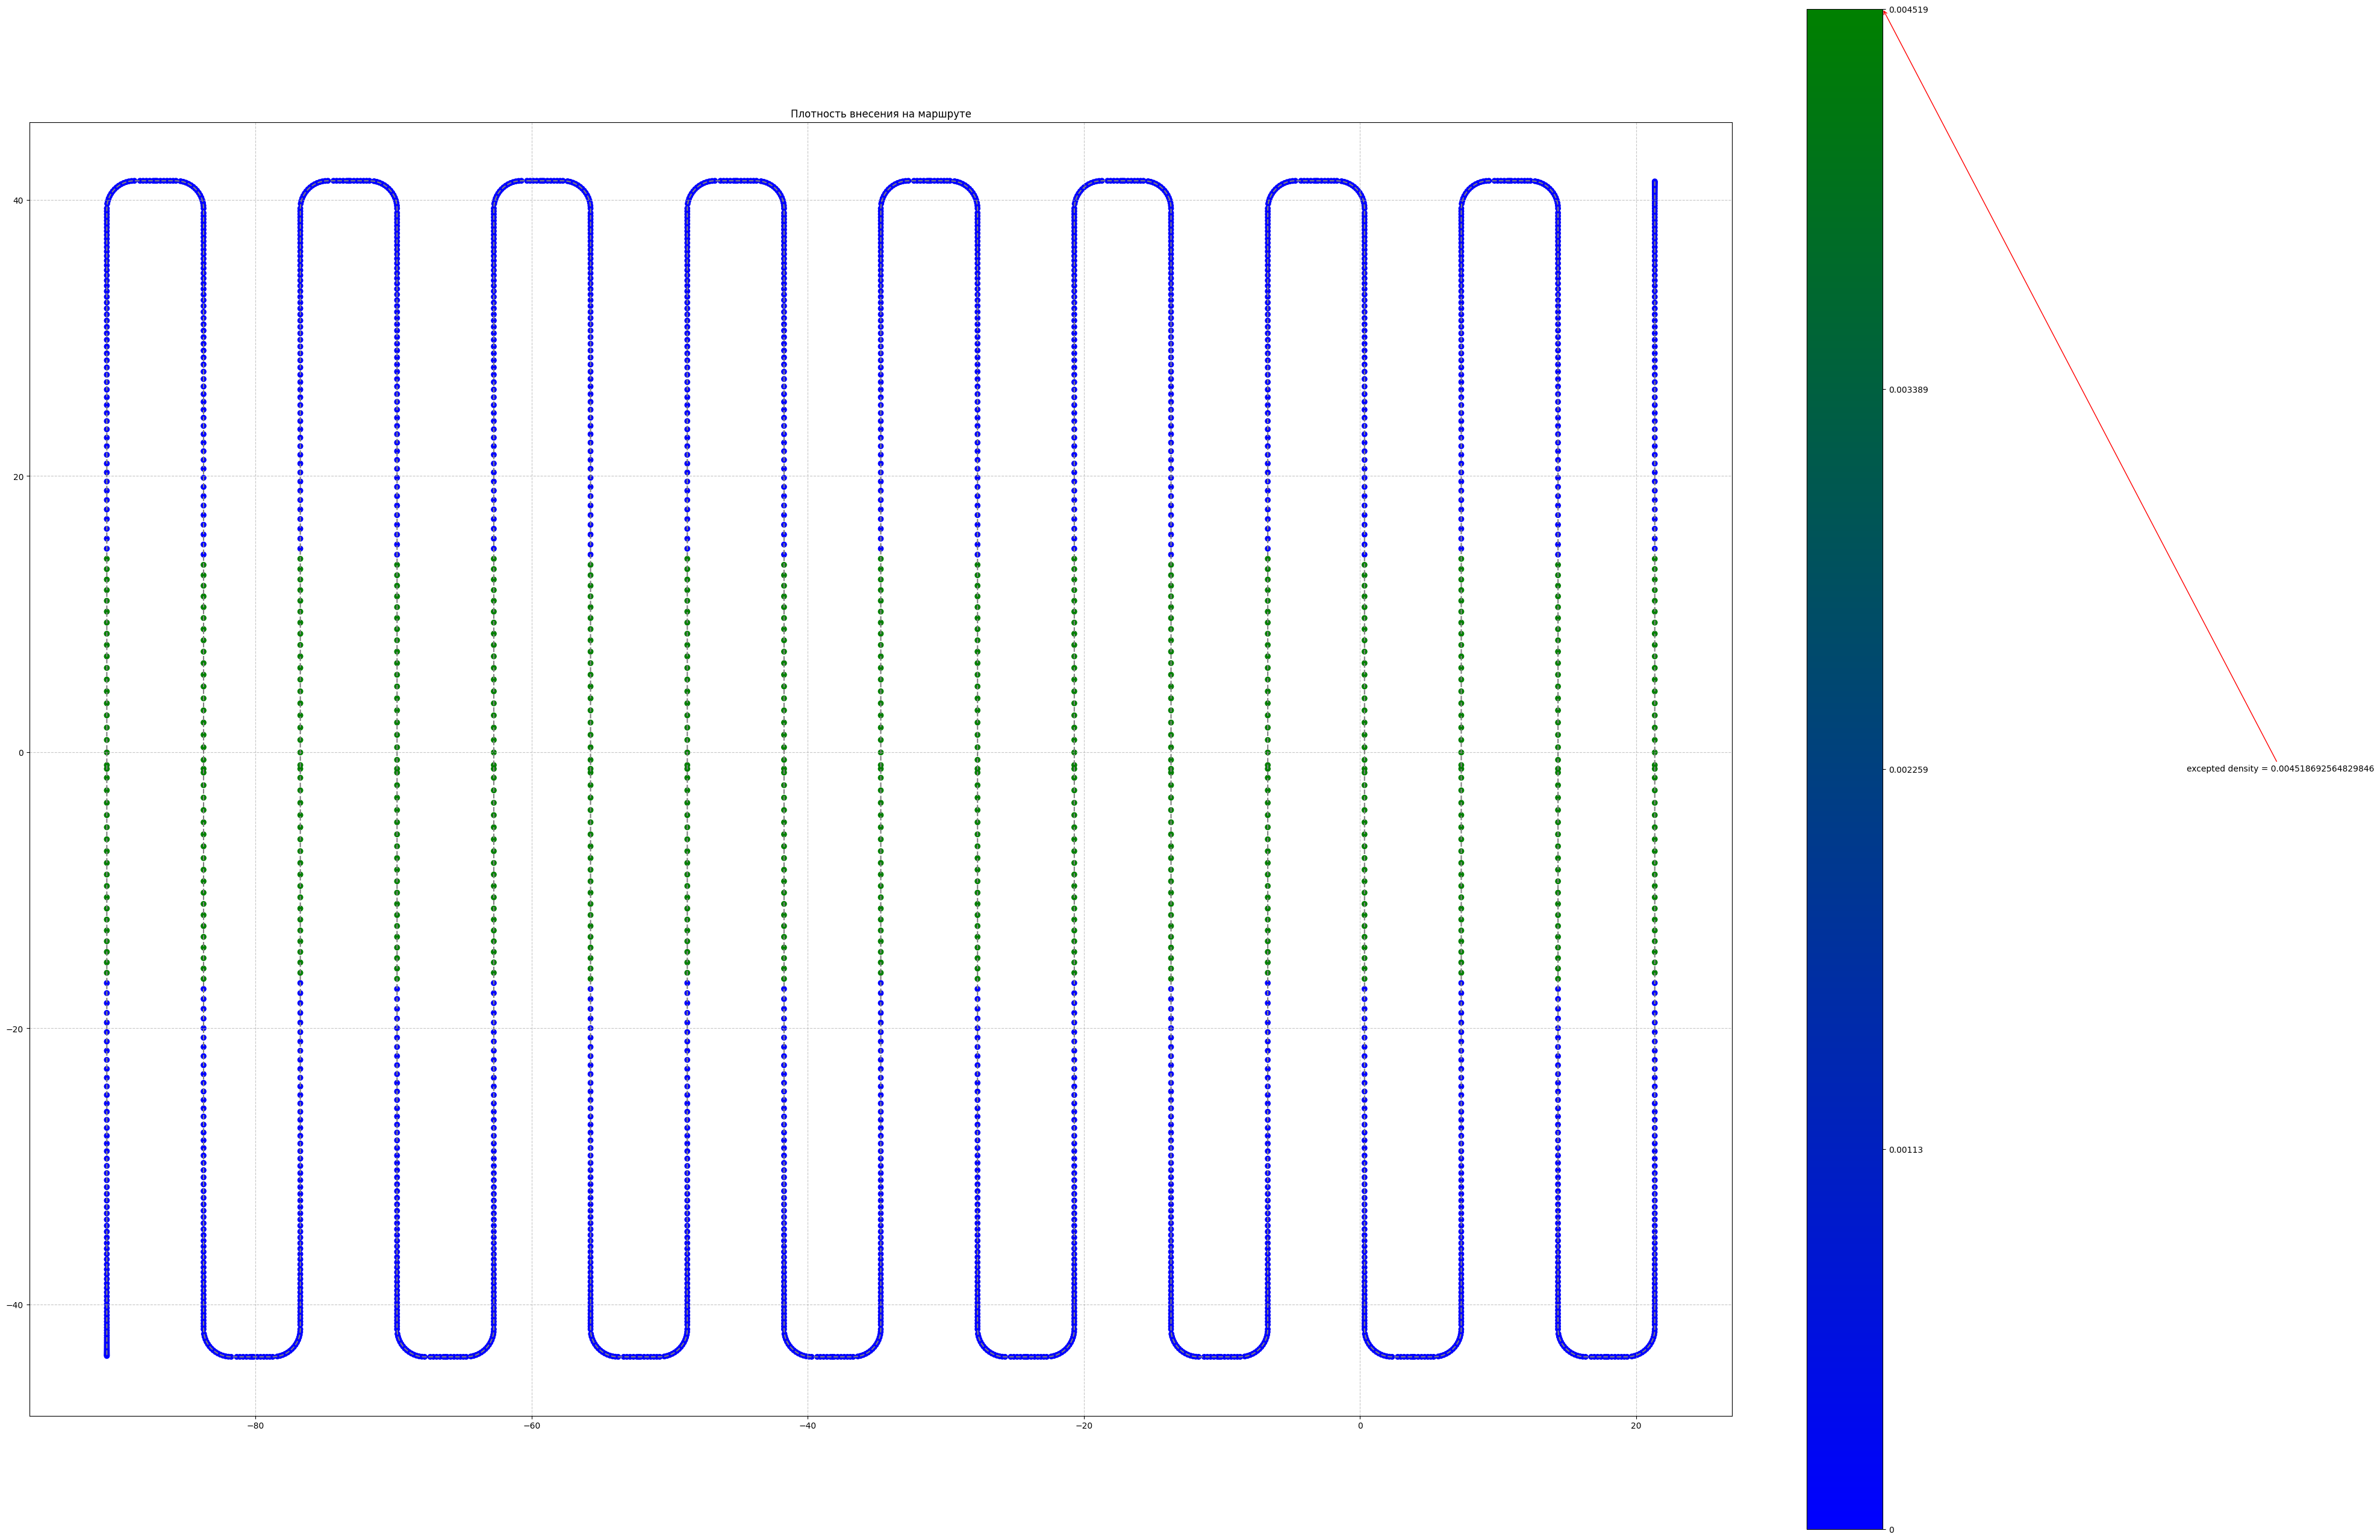

In [9]:
pf = PumpFacade.from_simple_params(plan=plan,
                                   norma=req_norma,
                                   max_drone_speed=drone_v_max,
                                   pump_min_speed=pump_min_speed,
                                   pump_max_speed=pump_max_speed,
                                   tank_volume=tank_volume,
                                   pumping_policy=PumpingPolicy.NoOverflowPolicy)

pf.plot()

In [3]:
pf.total_dispensed_by_pump_plan, pf.volume_total

(2.3604414410766634, 6.925970625177626)

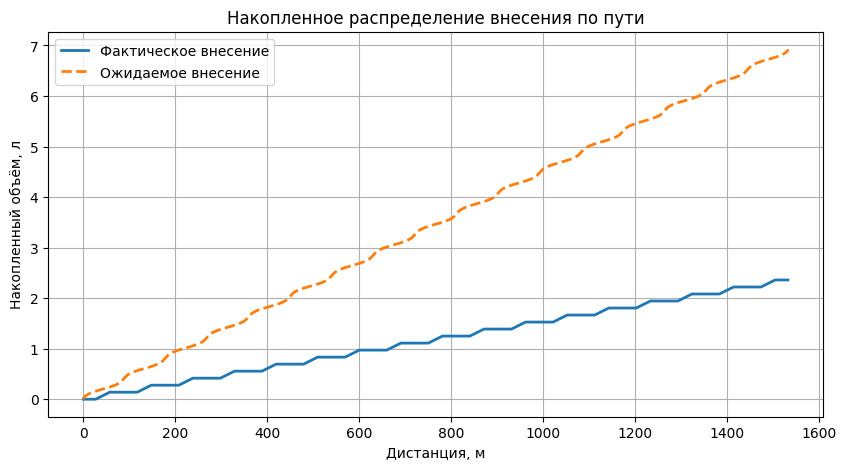

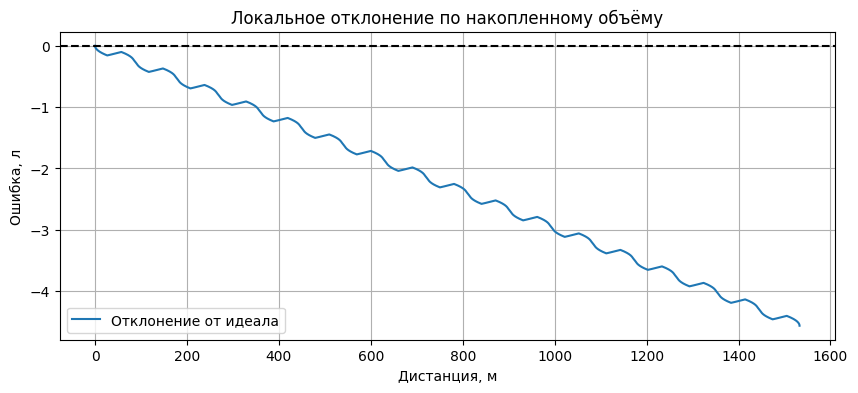

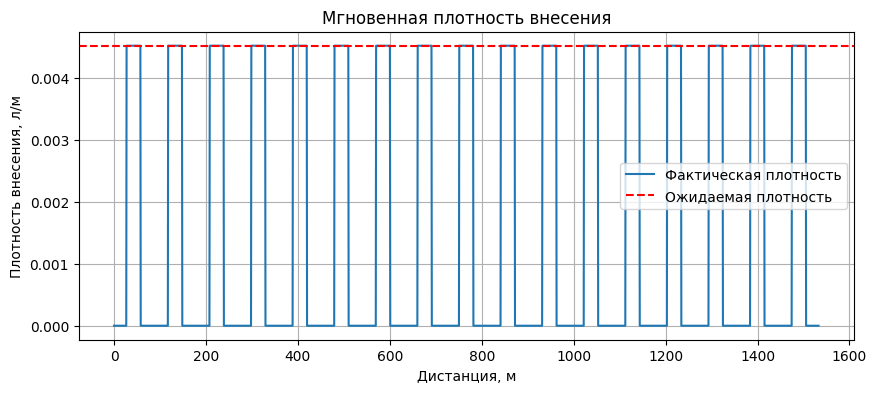

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# фактический накопленный объём по дистанции
# Δs между точками (в метрах)
ds = np.diff([0] + pf.s_list)  # список шагов по пути
fact_cumulative = np.cumsum(pf.instant_introduction_density * ds)

# ожидаемая линейная кривая (идеальное равномерное внесение)
expected_cumulative = np.linspace(0, pf.volume_total, len(pf.s_list))

# === Визуализация ===
plt.figure(figsize=(10, 5))
plt.plot(pf.s_list, fact_cumulative, label="Фактическое внесение", linewidth=2)
plt.plot(pf.s_list, expected_cumulative, label="Ожидаемое внесение", linestyle="--", linewidth=2)
plt.xlabel("Дистанция, м")
plt.ylabel("Накопленный объём, л")
plt.title("Накопленное распределение внесения по пути")
plt.legend()
plt.grid(True)
plt.show()

error = fact_cumulative - expected_cumulative
plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, error, label="Отклонение от идеала")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Дистанция, м")
plt.ylabel("Ошибка, л")
plt.title("Локальное отклонение по накопленному объёму")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, pf.instant_introduction_density, label="Фактическая плотность")
plt.axhline(pf.density, color="red", linestyle="--", label="Ожидаемая плотность")
plt.xlabel("Дистанция, м")
plt.ylabel("Плотность внесения, л/м")
plt.title("Мгновенная плотность внесения")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
abs_error = abs(pf.total_dispensed_by_pump_plan - pf.volume_total)
print(f"{abs_error=}")

abs_error=4.565529184100962


In [6]:
fact_density = pf.total_dispensed_by_pump_plan / pf.profile.total_distance
abs_density_error = abs(fact_density - pf.density)
rel_density_error = abs_density_error / pf.density

print(f"{abs_density_error=} {rel_density_error=}")

abs_density_error=0.0029786760434291617 rel_density_error=0.6591897989725986


In [7]:
pf.volume_total / pf.density

1532.7377390274896

In [8]:
pf.instant_introduction_density

array([0., 0., 0., ..., 0., 0., 0.], shape=(3194,))

In [9]:
from pprint import pprint
from metrics import TotalVolumeError, UniformityError, StopOverflowError, ErrorEvaluator

metrics = [
    TotalVolumeError(),
    UniformityError(),
    StopOverflowError(),
]

weights = {
    "rel_total_volume_error": 0.5,
    "mse_density": 0.3,
    "stop_overflow_ratio": 0.2,
}

# допустим, мы ожидаем что:
normalization = {
    "rel_total_volume_error": (0, 0.1),  # - относительная ошибка < 0.1 нормально
    "mse_density": (0, 0.01),  # - mse_density < 0.01 нормально
    "stop_overflow_ratio": (0, 0.05),  # - stop_overflow_ratio < 0.05 нормально
}

evaluator = ErrorEvaluator(metrics, weights=weights, normalization=normalization)

results = evaluator.evaluate(
    v_motion=pf.speed_list,
    v_pump=pf.pump_plan.q,
    dt=pf.dt,
    volume_total=pf.volume_total,
    target_density=pf.density,
)

pprint(results)


{'abs_total_volume_error': np.float64(4.494790573395762),
 'fact_total_volume': np.float64(2.4311800517818636),
 'integral_score': np.float64(0.5004885875097125),
 'mae_density': np.float64(0.0036041952600428537),
 'mse_density': np.float64(1.6286250323750612e-05),
 'rel_total_volume_error': np.float64(0.6489762686916517),
 'stop_overflow_ratio': np.float64(0.0),
 'stop_overflow_volume': np.float64(0.0)}


In [10]:
float(results['integral_score'])

0.5004885875097125

In [11]:
def try_compensate_by_decrease_drone_speed(plan: Plan,
                                           req_norma: float,  # Требуемая норма внесения Л/Га
                                           drone_v_min=2,  # минимально допустимая скорость дрона (м/с)
                                           drone_v_max=10.0,  # максимально допустимая скорость дрона (м/с)

                                           pump_min_speed=2,  # л/мин
                                           pump_max_speed=13,  # л/мин

                                           tank_volume=40,  # л
                                           pumping_policy: PumpingPolicy = PumpingPolicy.NoUnderfillPolicy,
                                           mse_eps=1e-4,  # допустимая ошибка плотности внесения
                                           _num=20,
                                           # число разбиений интервала для выбора наилучшего ограничения максимальной скорости дрона
                                           ):
    speed_values = np.linspace(drone_v_min, drone_v_max, num=_num)

    results = {}
    for v in speed_values:
        pf = PumpFacade.from_simple_params(plan=plan,
                                           norma=req_norma,
                                           max_drone_speed=v,
                                           pump_min_speed=pump_min_speed,
                                           pump_max_speed=pump_max_speed,
                                           tank_volume=tank_volume,
                                           pumping_policy=pumping_policy)

        results[v] = pf.mse_density

    min_mse = min(results.values())
    if min_mse > mse_eps:
        raise ValueError("Нерешаемая задача")

    # выбираем скорость, при которой ошибка минимальна
    best_v = min(results, key=results.get)

    return best_v, min_mse


In [12]:

# ==== Пример использования ====

# Тестовая функция ошибки
def error_func(x):
    pf = PumpFacade.from_simple_params(plan=plan,
                                       norma=x,
                                       max_drone_speed=2,
                                       pump_min_speed=pump_min_speed,
                                       pump_max_speed=pump_max_speed,
                                       tank_volume=tank_volume,
                                       pumping_policy=PumpingPolicy.NoUnderfillPolicy)
    # return float(abs(pf.total_dispensed_by_pump_plan - pf.volume_total))
    return pf.mse_density


In [13]:
from typing import Callable


class EvalCache:
    """Обёртка над func с кэшированием и счётчиком вызовов."""

    def __init__(self, func: Callable[[float], float]):
        self.func = func
        self.cache = {}
        self.n_calls = 0

    def __call__(self, x: float) -> float:
        self.n_calls += 1

        if x <= 0:
            raise ValueError("x должен быть > 0")

        key = float(x)
        if key in self.cache:
            return self.cache[key]

        y = self.func(x)
        self.cache[key] = y

        return y


In [14]:
from plots import plot_min_range


def find_optimal_error_interval(error_func, start_x, stop_x, n_points=100, delta=None, eps=None, log_s=False):
    """
    error_func(x) -> float
    alpha : допустимая доля превышения ошибки (например, 0.05 = 5%)
    beta  : коэффициент "резкости" за пределами интервала
    """
    assert sum([p is not None for p in (delta, eps)]) == 1, f"Должен быть задан порог одним из возможных способов ({eps} или {delta})"
    # сетка значений
    x_vals = np.logspace(np.log10(start_x), np.log10(stop_x), n_points) if log_s else np.linspace((start_x), (stop_x), n_points)
    errors = np.array([error_func(x) for x in x_vals])

    # минимум
    min_index = np.argmin(errors)
    x_min, y_min = x_vals[min_index], errors[min_index]

    # допуск
    if eps is None:
        eps = y_min * delta

    # интервал (все x, где ошибка <= e_min + tau)
    mask = errors <= y_min + eps

    if not np.any(mask):
        return None, (x_min, y_min), "Интервал не найден"

    [where] = np.where(mask)
    i_left = where[0]
    i_right = where[-1]

    x_left, x_right = x_vals[i_left], x_vals[i_right]

    plot_min_range(error_func,
                   left_bound=x_left, right_bound=x_right,
                   start_x=start_x, stop_x=stop_x,
                   x_min=x_min, eps=eps, )

    return (x_left, x_right), (x_min, y_min)


In [15]:
f = EvalCache(error_func)

In [19]:
# @EvalCache
# def fabs(x):
#     pf = PumpFacade.from_simple_params(plan=plan,
#                                        norma=x,
#                                        max_drone_speed=2,
#                                        pump_min_speed=pump_min_speed,
#                                        pump_max_speed=pump_max_speed,
#                                        tank_volume=tank_volume,
#                                        pumping_policy=PumpingPolicy.NoUnderfillPolicy)
#     return float(abs(pf.total_dispensed_by_pump_plan - pf.volume_total))

In [20]:
from IntervalFinder import ErrorIntervalFinder, BrentMin, RootBounds

start_x = 1.e-5
stop_x = 300


finder = ErrorIntervalFinder(BrentMin(), RootBounds())
interval, optimum, calls = finder.find_interval(fabs, start_x, stop_x, eps=1)
print("  Интервал:", interval, "Оптимум:", optimum, "Вызовов:", calls)


import math
l, r = interval
ls = math.ceil(l)
rs = math.floor(r)

print(ls, rs)

  Интервал: (24.871996348206977, 168.84170533535334) Оптимум: (np.float64(167.82849234309515), np.float64(2.874665767649276e-06)) Вызовов: 51
25 168


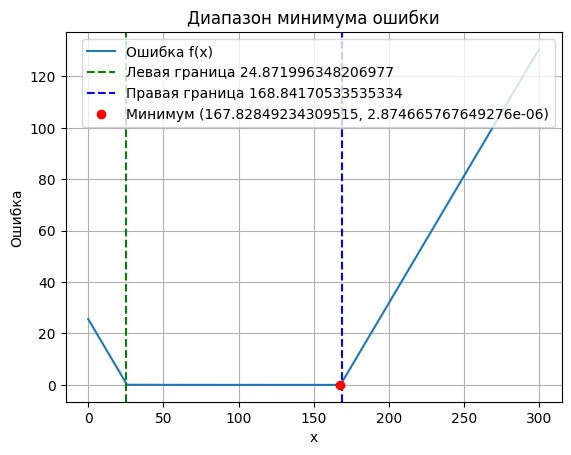

In [21]:
plot_min_range(fabs,
               left_bound=interval[0], right_bound=interval[1],
               start_x=start_x, stop_x=stop_x,
               x_min=optimum[0],)

In [59]:
len(fabs.cache)

547

In [60]:
fabs.n_calls

552

In [61]:
fabs(169)

1.1562489692406928

In [62]:
fabs(26)

0.0628750291177873

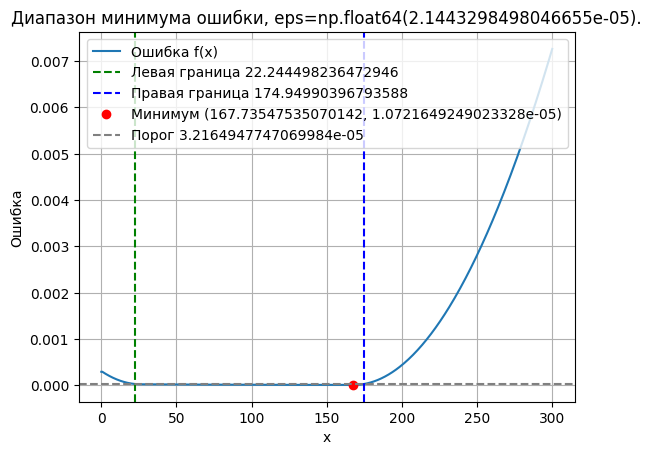

In [63]:
start_x = 1.e-5
stop_x = 300

error_interval = find_optimal_error_interval(
    f,
    start_x=start_x,
    stop_x=stop_x,
    n_points=500,
    delta=2,  # % допуска
)
interval, optimum = error_interval

In [64]:
f.n_calls

1001

In [65]:
diff = pf.instant_introduction_density

# Эксперимент с поиском оптимальной скорости

In [66]:
# from functools import cache
# from norma_search import NormaSearcher
# from ErrorStrategy import VolumeAbsError, DensityMSE, CompositeError
#
# @cache
# def temp_calc(drone_v_max: float) -> dict:
#     req_norma_guess_low = 0.1
#     req_norma_guess_high = 1000.0
#
#     pump_min_speed = 2  # л/мин
#     pump_max_speed = 13  # л/мин
#     tank_volume = 40  # л
#
#     log_file_path = Path(
#         r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")
#
#     plan = Plan.get_plan_from_log_file(log_file_path)
#
#     # 1) чисто по объёму
#     strategy_volume = VolumeAbsError()
#
#     # 2) чисто по равномерности
#     strategy_density = DensityMSE()
#
#     # 3) комбинированная цель с весами
#     strategy_combo = CompositeError([
#         (strategy_volume, 1),
#         (strategy_density, 0),
#     ])
#
#     permissible_error = 1  # Согласно выбранной стратегии расчёта ошибки
#     strategy = strategy_combo
#
#     policy = PumpingPolicy.NoUnderfillPolicy
#
#     searcher = NormaSearcher()
#
#     err_func = searcher.make_error_func(
#         plan=plan,
#         max_drone_speed=drone_v_max,
#         pump_min_speed=pump_min_speed,
#         pump_max_speed=pump_max_speed,
#         tank_volume=tank_volume,
#         pumping_policy=policy,  # пример
#         strategy=strategy,
#     )
#
#     (left_bound, right_bound), (x_minimum_err, min_error), calls = searcher.find_interval(
#         error_func=err_func,
#         start_x=req_norma_guess_low,
#         stop_x=req_norma_guess_high,
#         eps=permissible_error
#     )
#     return {
#         "left_bound": left_bound,
#         "right_bound": right_bound,
#         "x_minimum_err": x_minimum_err,
#         "min_error": min_error,
#         "calls": calls,
#     }


In [68]:
def plot_norma_interval_by_speed(data):
    # подготовка данных
    x = list(data.keys())
    left = [v['left_bound'] for v in data.values()]
    right = [v['right_bound'] for v in data.values()]
    minimum = [v['x_minimum_err'] for v in data.values()]


    plt.figure(figsize=(10, 6))

    # линии нижних и верхних границ
    plt.plot(x, left, linestyle='--', label='Минимально допустимая')
    plt.plot(x, right, linestyle='--', label='Максимально допустимая')

    # заливка между границами
    plt.fill_between(x, left, right, color='lightblue', alpha=0.5)

    # точки минимума ошибки
    plt.scatter(x, minimum, color='red', zorder=5, label='Наилучшая')

    plt.xlabel('Скорость')
    plt.ylabel('Допустимая норма внесения')
    plt.title('Визуализация допустимых диапазонов')
    plt.legend()
    plt.grid(True)
    plt.show()

In [144]:
np.linspace(1, 11, 41)

array([ 1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,
        3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,
        5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,
        7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75,
       10.  , 10.25, 10.5 , 10.75, 11.  ])

In [145]:
res = {}
for drone_v_max in np.linspace(1, 11, 41):
    res[drone_v_max] = temp_calc(drone_v_max=drone_v_max)

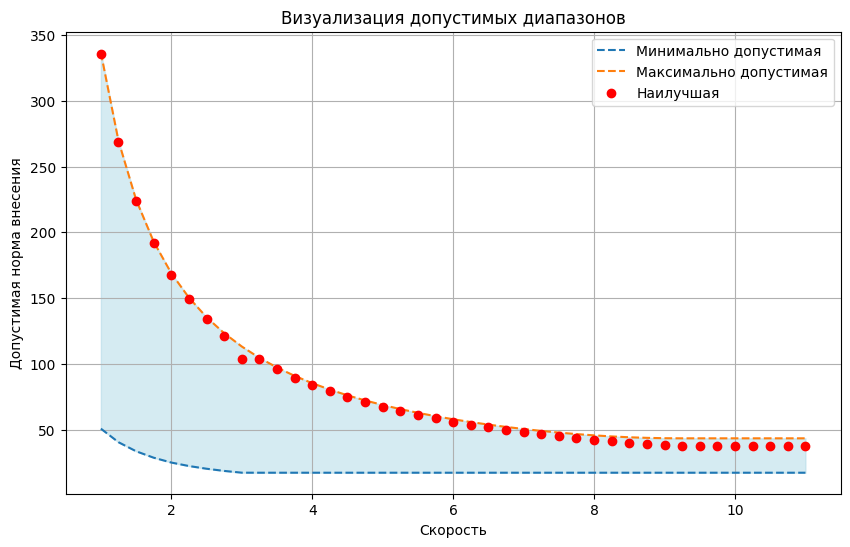

In [146]:
plot_norma_interval_by_speed(res)

In [147]:
x = np.array([float(k) for k in res.keys()])
y1 = np.array([v['left_bound'] for v in res.values()])
y2 = np.array([v['right_bound'] for v in res.values()])

In [155]:
def appro(x, y):
    import numpy as np
    from scipy.optimize import curve_fit
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt

    # Модели
    def model_exp(x, A, k, C):
        return A * np.exp(-k * x) + C

    def model_double_exp(x, A1, k1, A2, k2, C):
        return A1 * np.exp(-k1 * x) + A2 * np.exp(-k2 * x) + C

    def model_power(x, A, p, C):
        return A / (x**p) + C

    models = {
        "Экспонента": (model_exp, [0, 0, 0], [np.inf, 10, np.inf]),
        "Две экспоненты": (model_double_exp, [0, 0, 0, 0, 0], [np.inf, 10, np.inf, 10, np.inf]),
        "Степенной закон": (model_power, [0, 0, 0], [np.inf, 10, np.inf])
    }

    results = {}

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label="Данные", color="black")

    for name, (f, lower, upper) in models.items():
        try:
            params, _ = curve_fit(f, x, y, bounds=(lower, upper), maxfev=20000)
            y_pred = f(x, *params)

            rmse = np.sqrt(mean_squared_error(y, y_pred))
            r2 = r2_score(y, y_pred)

            results[name] = {"params": params, "rmse": rmse, "r2": r2}

            plt.plot(x, y_pred, label=f"{name} (R²={r2})")
        except RuntimeError:
            results[name] = {"params": None, "rmse": None, "r2": None}

    plt.axhline(y=min(y), color="black", linestyle="--", label=f'{min(y) = }')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Аппроксимация разных моделей")
    plt.show()

    # Вывод параметров и метрик
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"  Параметры: {res['params']}")
        print(f"  RMSE = {res['rmse']}")
        print(f"  R²   = {res['r2']}")



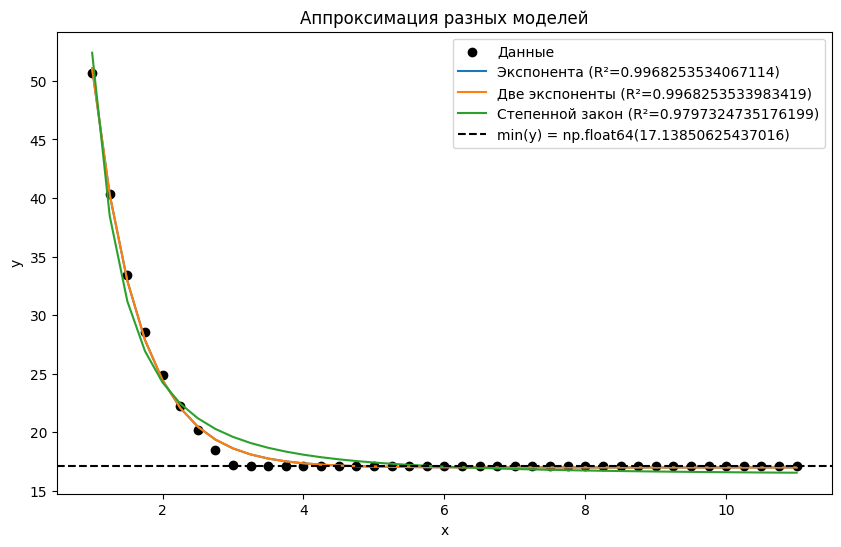


Экспонента:
  Параметры: [155.85805761   1.52059973  16.99310985]
  RMSE = 0.38382450926283196
  R²   = 0.9968253534067114

Две экспоненты:
  Параметры: [132.51500778   1.5206141   23.34408636   1.52055273  16.99311335]
  RMSE = 0.3838245097687823
  R²   = 0.9968253533983419

Степенной закон:
  Параметры: [36.05141037  2.19174825 16.35715036]
  RMSE = 0.9698071572620995
  R²   = 0.9797324735176199


In [148]:
appro(x, y1)

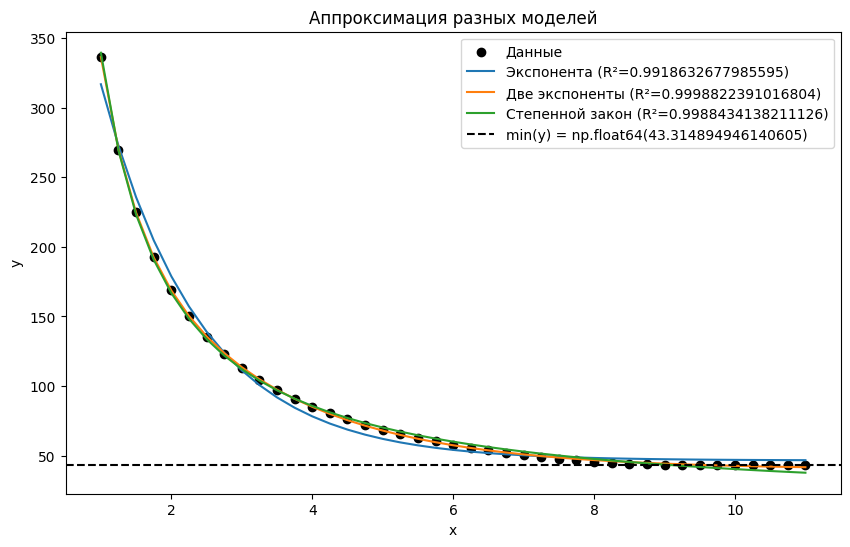


Экспонента:
  Параметры: [552.43463518   0.7143939   46.50763431]
  RMSE = 5.948747446503738
  R²   = 0.9918632677985595

Две экспоненты:
  Параметры: [9.41837412e+02 2.13803952e+00 2.97797250e+02 4.73361189e-01
 4.00429055e+01]
  RMSE = 0.715650658225527
  R²   = 0.9998822391016804

Степенной закон:
  Параметры: [325.69970271   1.09052519  13.87264094]
  RMSE = 2.2427946899625444
  R²   = 0.9988434138211126


In [149]:
appro(x, y2)

## 1

In [13]:
from ErrorStrategy import DensityMSE, VolumeAbsError, CompositeError
import searchers


pump_min_speed = 1  # л/мин
pump_max_speed = 13  # л/мин
tank_volume = 40  # л

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(log_file_path)

# 1) чисто по объёму
strategy_volume = VolumeAbsError()

# 2) чисто по равномерности
strategy_density = DensityMSE()

# 3) комбинированная цель с весами
strategy_combo = CompositeError([
    (strategy_volume, 1),
    (strategy_density, 0),
])

permissible_error = 1 # Согласно выбранной стратегии расчёта ошибки
strategy = strategy_combo

policy = PumpingPolicy.NoUnderfillPolicy


req_norma_guess_low = 0.5
req_norma_guess_high = 300.0
req_norma = 100

drone_v_min = 1.0
drone_v_max = 11.0

start_x = drone_v_min
stop_x = drone_v_max

err_func = searchers.make_error_func_by_max_drone_speed(
    plan=plan,
    norma=req_norma,
    pump_min_speed=pump_min_speed,
    pump_max_speed=pump_max_speed,
    tank_volume=tank_volume,
    pumping_policy=policy,  # пример
    strategy=strategy,
)

In [188]:
x = np.linspace(1, 11, 41)
y = [err_func(v) for v in x]

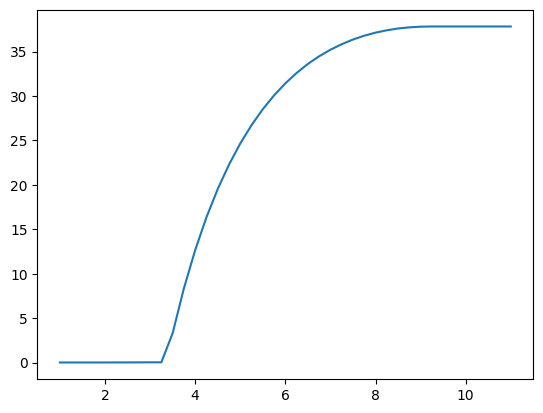

In [189]:
plt.plot(x, y)

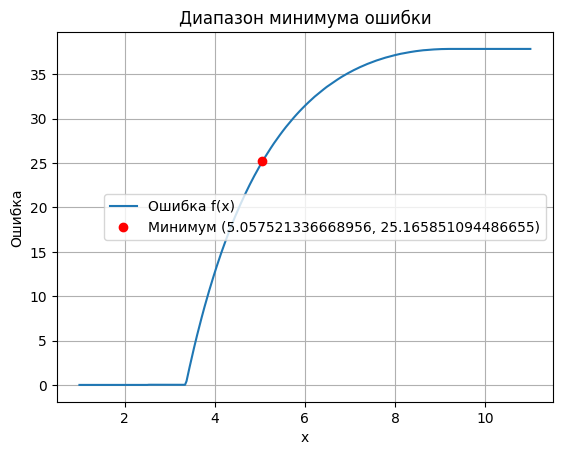

In [190]:
points = 300
plot_min_range(err_func, left_bound, right_bound, start_x, stop_x, x_min=x_minimum_err, points=points)

## 2

In [6]:
from functools import cache


@cache
def mesh_err(norma: float, max_drone_speed: float) -> float:
    pf = PumpFacade.from_simple_params(
        plan=plan,
        norma=norma,
        max_drone_speed=max_drone_speed,
        pump_min_speed=pump_min_speed,
        pump_max_speed=pump_max_speed,
        tank_volume=tank_volume,
        pumping_policy=policy,
    )
    res = pf.build_result()
    return float(strategy(res))

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [205]:


# задаём диапазоны параметров
norma_vals = np.linspace(0.5, 400.0, 100)          # пример диапазона для norma
max_speed_vals = np.linspace(1.0, 11.0, 82)     # пример диапазона для max_drone_speed

# создаём сетку координат
X, Y = np.meshgrid(max_speed_vals, norma_vals)

# вычисляем значения mesh_err для каждой точки
Z = np.zeros_like(X, dtype=float)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = mesh_err(Y[i, j], X[i, j])   # Y = norma, X = max_drone_speed

In [2]:
def calc_mesh(x_bounds, y_bounds, size, func):

    # задаём диапазоны параметров
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x_num, y_num = size

    x_vals = np.linspace(x_min, x_max, x_num)     # пример диапазона для max_drone_speed
    y_vals = np.linspace(y_min, y_max, y_num)          # пример диапазона для norma

    # создаём сетку координат
    X, Y = np.meshgrid(x_vals, y_vals)

    # вычисляем значения mesh_err для каждой точки
    Z = np.zeros_like(X, dtype=float)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(Y[i, j], X[i, j])   # Y = norma, X = max_drone_speed

    return X, Y, Z

In [3]:
def view_mesh(X, Y, Z):
    # визуализация через imshow (матрица)
    plt.figure(figsize=(7, 6))
    plt.imshow(Z,
               extent=(X.min(), X.max(), Y.min(), Y.max()),
               origin="lower",
               aspect="auto",
               cmap="viridis")
    plt.colorbar(label="error")
    plt.xlabel("max_drone_speed")
    plt.ylabel("norma")
    plt.title("Abs volume err на сетке параметров")
    plt.show()

In [4]:
import time

In [ ]:
int.__add__(1,2)

1 Time: 0.0005130767822265625


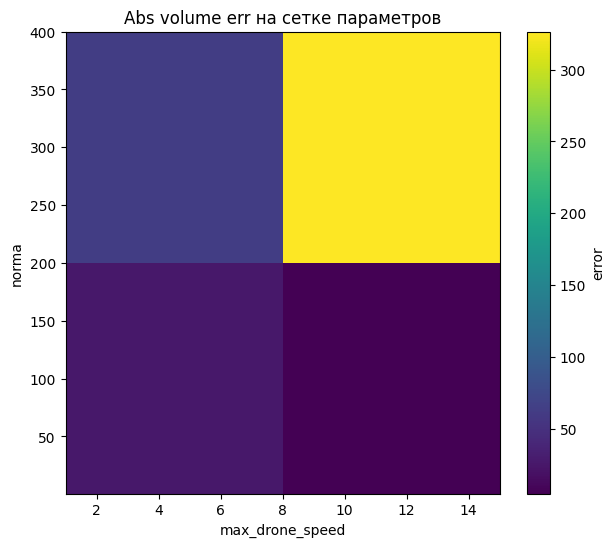

2 Time: 0.00041604042053222656


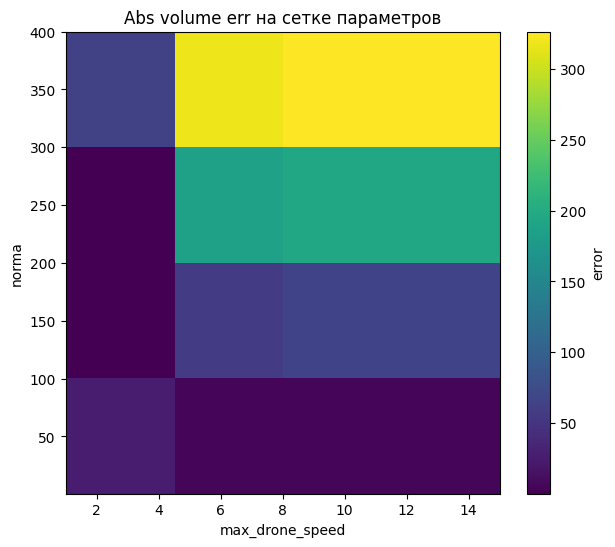

3 Time: 0.0004000663757324219


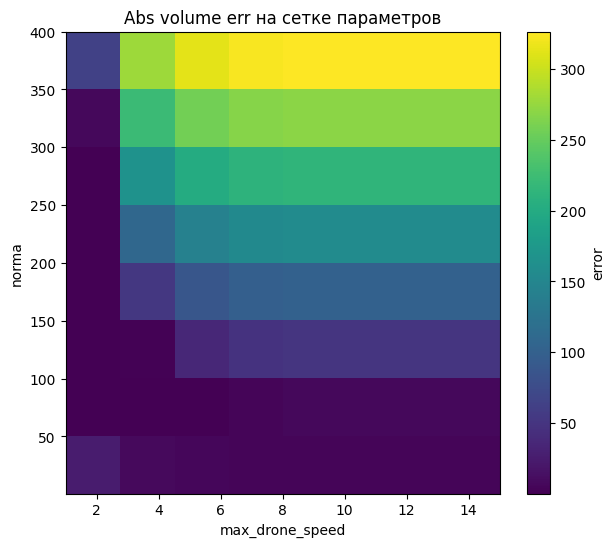

4 Time: 10.947437286376953


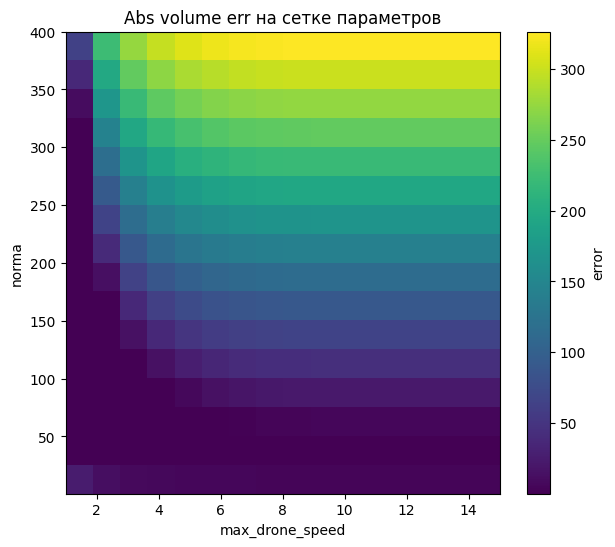

In [ ]:
deep = 10
x_bounds = 1, 15
y_bounds = 0.5, 400

for i in range(1, deep + 1):
    size = (2**i, 2**i)
    start = time.time()
    x, y, z = calc_mesh(x_bounds, y_bounds, size, mesh_err)
    end = time.time()
    print(f"{i} Time: {end - start}")
    view_mesh(x, y, z)

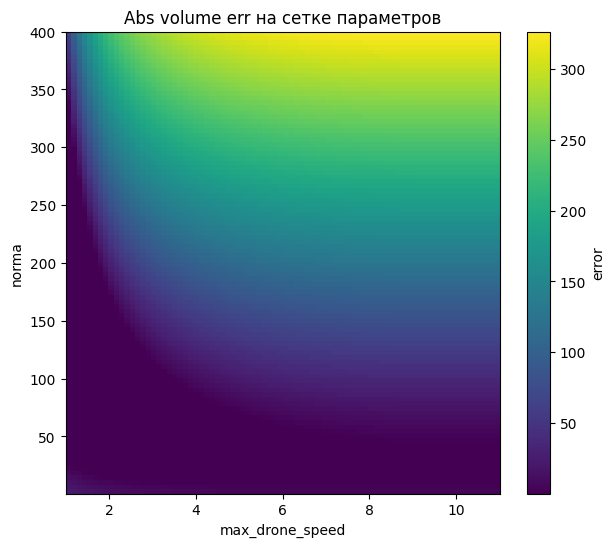

In [218]:
# визуализация через imshow (матрица)
plt.figure(figsize=(7, 6))
plt.imshow(Z,
           extent=(X.min(), X.max(), Y.min(), Y.max()),
           origin="lower",
           aspect="auto",
           cmap="viridis")
plt.colorbar(label="error")
plt.xlabel("max_drone_speed")
plt.ylabel("norma")
plt.title("Abs volume err на сетке параметров")
plt.show()

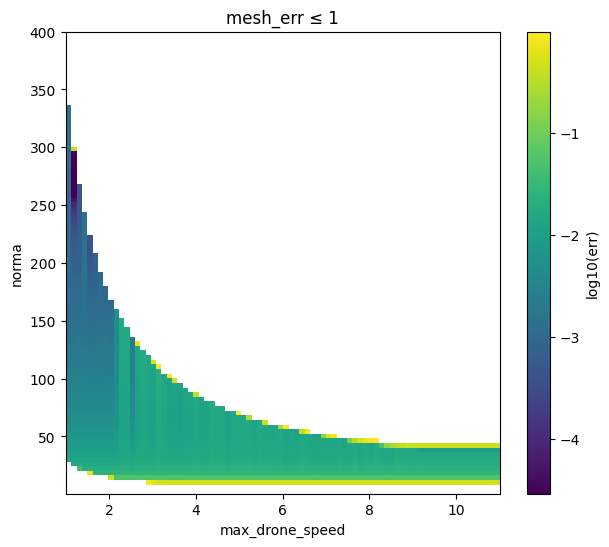

In [222]:
# порог
threshold = 1

# фильтруем: всё, что выше порога, делаем NaN
Z_filtered = np.where(Z <= threshold, np.log10(Z), np.nan)

# вариант 1: imshow
plt.figure(figsize=(7, 6))
plt.imshow(Z_filtered,
           extent=(X.min(), X.max(), Y.min(), Y.max()),
           origin="lower",
           aspect="auto",
           cmap="viridis")
plt.colorbar(label="log10(err)")
plt.xlabel("max_drone_speed")
plt.ylabel("norma")
plt.title(f"mesh_err ≤ {threshold}")
plt.show()

# ещё

In [71]:
# pf = PumpFacade.from_simple_params(plan=plan,
#                                    norma=req_norma,
#                                    max_drone_speed=drone_v_max,
#                                    pump_min_speed=pump_min_speed,
#                                    pump_max_speed=pump_max_speed,
#                                    tank_volume=tank_volume,
#                                    pumping_policy=PumpingPolicy.NoOverflowPolicy)
#
# pf.plot()
# d = pf.density

In [72]:
# policy = PolicyFactory.with_tolerance(over_tol=0.5,  # Допускаем переливать 0,5 л
#                                       under_tol=0.5,  # Допускаем не доливать 0,5 л
#                                       w_over=2,  # Переливание в 2 раза хуже
#                                       violation=ViolationMode.IGNORE  # Кидаем исключения при нарушениях
#                                       )
#
# target = 0
# x = np.linspace(-10, 10, 21) / 10
# y = [policy.cost(target, i) for i in x]
# plt.plot(x, y)